In [9]:
from stackapi import StackAPI
from datetime import datetime as dt, date
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
import math
from collections import Counter
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.io as pio

In [10]:
# Import DataFrames if previously saved
df_sql=pd.read_csv('df_sql.csv')
df_adf=pd.read_csv('df_adf.csv')
df_synapse=pd.read_csv('df_synapse.csv')
df_databricks=pd.read_csv('df_databricks.csv')
df_powerbi=pd.read_csv('df_powerbi.csv')

In [11]:
pd.options.plotting.backend='plotly'

In [12]:
# Scraping Functions

# Use Stack Overflow StackAPI API for Python: https://stackapi.readthedocs.io/en/latest/
def count_pages(tag):
    response = StackAPI('stackoverflow')
    pages = response.fetch('tags', inname=tag, sort='popular')['items'][0]['count']
    print('{} questions'.format(pages))

    
def fetch_latest_question(tag, order_bin):
    response = StackAPI('stackoverflow')
    if order_bin == 0:
        order = 'asc'
    else: 
        order = 'desc'
    pages = response.fetch('questions', tagged=tag, sort='creation', order=order,pagesize=1)['items']
    latest_id = pages[0]['question_id']
    latest_creation_timestamp = pages[0]['creation_date']
    return latest_creation_timestamp


# Use Stack Overflow StackAPI API for Python: https://stackapi.readthedocs.io/en/latest/
def scrape_page(tag, page_questions, from_timestamp):
    response = StackAPI('stackoverflow')
    pages = response.fetch('questions', tagged=tag, sort='creation', order='asc', fromdate=from_timestamp)['items']
    for page in pages:
        title = page['title']
        is_answered = page['is_answered'] # Question marked as answered by original poster
        creation_timestamp = page['creation_date']
        creation_date = dt.fromtimestamp(creation_timestamp).date()
        year = creation_date.year
        month = creation_date.month
        answer_count = page['answer_count'] # Submitted answer count
        score = page['score']
        view_count = page['view_count']
        tags = str(page['tags'])
        page_questions.append({
            "title": title,
            "is_answered": is_answered,
            "creation_timestamp": creation_timestamp,
            "creation_date": creation_date,
            "year": year,
            "month": month,
            "answer_count": answer_count,
            "score": score,
            "view_count": view_count,
            "tags": tags,
        })
        
    return page_questions

In [13]:
# Data Processing Functions

# Run scrape and insert to Pandas DataFrame
def get_data(tag, timestamp=1):
    first_creation_timestamp = fetch_latest_question(tag, 0)
    latest_creation_timestamp = fetch_latest_question(tag, 1)
    mid_timestamp = (first_creation_timestamp + latest_creation_timestamp) * 0.75
    print(mid_timestamp)
    if timestamp == 0:
        local_creation_timestamp = 0
        end_point = mid_timestamp
    elif timestamp == 1:
        local_creation_timestamp = 0
        end_point = latest_creation_timestamp
    else:
        local_creation_timestamp = timestamp
        end_point = latest_creation_timestamp
    page_questions = []
    while local_creation_timestamp < end_point:
        print('Performing API call...')
        page_questions = scrape_page(tag, page_questions, local_creation_timestamp)
        local_creation_timestamp = page_questions[-1]['creation_timestamp']
        print(local_creation_timestamp)
        time.sleep(60)
    print("complete")
    # Insert data into DataFrame
    cols = list(page_questions[0].keys())
    df = pd.DataFrame(columns=cols)
    for q in page_questions:
        df2 = pd.DataFrame(q, columns = cols, index=[0])
        df = df.append(df2, ignore_index=True)
    return df


# Process DataFrame columns
def data_cleansing(df):
    df['year'] = pd.to_numeric(df['year'])
    df['month'] = pd.to_numeric(df['month'])
    df['answer_count'] = pd.to_numeric(df['answer_count'])
    df['score'] = pd.to_numeric(df['score'])
    df['view_count'] = pd.to_numeric(df['view_count'])
    df['year_month'] = df.year * 100 + df.month
    return df

In [14]:
# Analysis functions

# Initial Exploratory Data Analysis (EDA)
def eda(df):
    # Initial data exploration
    df_description = df.describe()
    # Explore most viewed questions
    most_viewed = df.sort_values(by=['view_count'], ascending=False)
    # Explore most voted questions
    most_voted = df.sort_values(by=['score'], ascending=False)
    # Unanswered questions
    unanswered = df[df.is_answered == False]
    df_filter = df[df.score>=0]
    unanswered_filter = df_filter[df_filter.is_answered == False]
    # Explore most viewed unanswered questions
    most_viewed_unanswered = unanswered.sort_values(by=['view_count'], ascending=False)
    # Explore most voted unanswered questions
    most_voted_unanswered = unanswered.sort_values(by=['score'], ascending=False)
    return df_description, most_viewed, most_voted, most_viewed_unanswered, most_voted_unanswered

# Questions per year
def years_view(df):
    df_group = df.groupby('year').count().reset_index()
    df_group = df_group[['year', 'title']].rename(columns={'title':'count'})
    fig = px.bar(df_group,
                x='year',
                y='count',
                title='',
                labels=dict(year='Year',count='Number of questions asked'))
    fig.update_layout(xaxis = dict(dtick = 1))
    fig.show('png')
    

# Questions per month
def months_view(df):    
    df_group = df.groupby('year_month').count().reset_index()
    df_group = df_group[['year_month', 'title']].rename(columns={'title':'count'})
    fig = px.bar(df_group,
                x='year_month',
                y='count',
                title='',
                labels=dict(year_month='Year/Month',count='Number of questions asked'))
    fig.update_xaxes(type='category')
    fig.show('png')
    
    
# Answered vs Unanswered questions
def pie_chart(df):
    df_group = df.groupby('is_answered').count().reset_index()
    df_group = df_group[['is_answered', 'title']].rename(columns={'title':'count'})
    fig = px.pie(df_group,
                values= 'count',
                names='is_answered',
                title='Answered Vs Unanswered Questions',
                labels=dict(is_answered='Answered'))
    fig.update_traces(textposition='inside', textinfo='percent+label')
    fig.update(layout_showlegend=False)
    fig.show('png')
    
# Investigate question tags
def tags_view(df):
    tags_full_list = []
    lists = list(df.tags)
    
    def clean_tags(tag):
        return tag.replace("[","").replace("]","").replace("'","").replace(",","").split()
    
    for tags_all in df.tags:
        tags = clean_tags(tags_all)
        for tag in tags:
            tags_full_list.append(tag)
    tags_count = Counter(tags_full_list)
    most_common_tags = tags_count.most_common()
    return most_common_tags


In [ ]:
df_sql = get_data("azure-sql-database")
df_sql = data_cleansing(df_sql)
df_mi = get_data("azure-sql-managed-instance")
df_mi = data_cleansing(df_mi)
df_adf = get_data("azure-data-factory")
df_adf = data_cleansing(df_adf)
df_synapse = get_data("azure-synapse")
df_synapse = data_cleansing(df_synapse)
df_databricks = get_data("databricks")
df_databricks = data_cleansing(df_databricks)

In [223]:
# Partition workload to prevent hitting quota limit from IP
df_powerbi_1 = get_data("powerbi",0)
# Wait to run part 2
ts = df_powerbi_1['creation_timestamp'].iloc[-1]
df_powerbi_2 = get_data("powerbi",ts)
# Concatenate two DataFrames
df_powerbi = pd.concat([df_powerbi_1, df_powerbi_2])
df_powerbi = data_cleansing(df_powerbi)

2233334042.25
Performing API call...
1507172396
Performing API call...
1520131713
Performing API call...
1529928931
Performing API call...
1537564220
Performing API call...
1544871426
Performing API call...
1552959761
Performing API call...
1559232477
Performing API call...
1565456280
Performing API call...
1571323467
Performing API call...
1577129970
Performing API call...
1582159635
Performing API call...
1587949552
Performing API call...
1592937905
Performing API call...
1598393643
Performing API call...
1603360584
Performing API call...
1608109719
Performing API call...
1612521952
Performing API call...
1615906833
Performing API call...
1619131348
Performing API call...
1622816439
Performing API call...
1626425481
Performing API call...
1630415695
Performing API call...
1634033573
Performing API call...
1637756946
Performing API call...
1640777415
complete


In [15]:
# Function to analyse year-on-year interest in technologies
def comparative_year(df):
    df['comparative_year'] = df['year'] - df['year'].min()
    df = df.fillna(0)
    return df

df_sql = comparative_year(df_sql)
# df_mi = comparative_year(df_mi)
df_adf = comparative_year(df_adf)
df_synapse = comparative_year(df_synapse)
df_databricks = comparative_year(df_databricks)
df_powerbi = comparative_year(df_powerbi)

In [16]:
# Merge DataFrames
df_sql['Technology'] = 'Azure SQL Database'
# df_mi['Technology'] = 'Azure SQL Managed Instance'
df_adf['Technology'] = 'Azure Data Factory'
df_synapse['Technology'] = 'Azure Synapse'
df_databricks['Technology'] = 'Databricks'
df_powerbi['Technology'] = 'Power BI'
df_all = pd.concat([df_sql,df_adf,df_synapse,df_databricks, df_powerbi])

In [21]:
!pip3 install -U kaleido

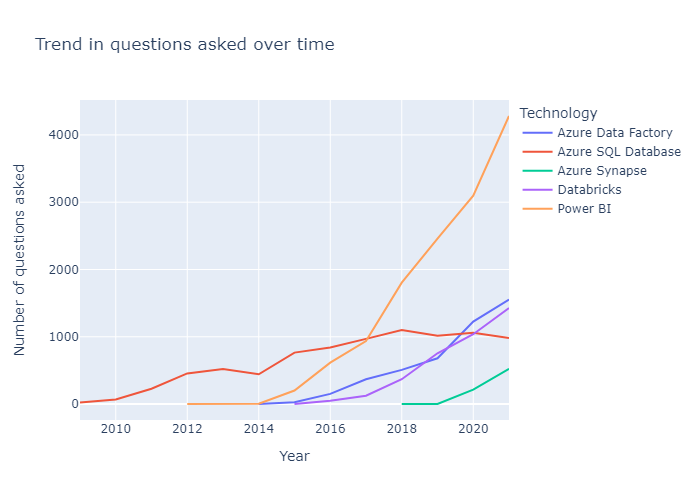

In [17]:
# Plot overall trend in questions per technology over time
df_pivot = pd.pivot_table(df_all,index=['year'],columns=['Technology'],values='month',aggfunc=len).reset_index()
fig = df_pivot.plot(x='year',
              y=list(df_pivot.columns[1:]), 
              labels=dict(
                  year='Year',
                  value='Number of questions asked',
                  variable='Technology'),
              title='Trend in questions asked over time'
              )
fig.show("png")

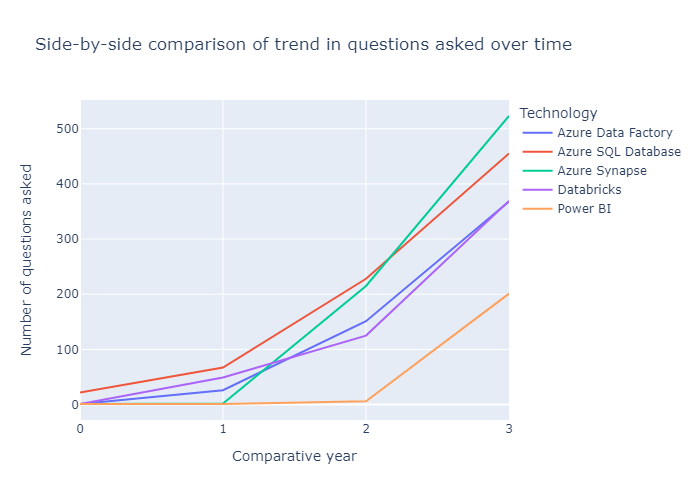

In [19]:
# Plot comparative interest in questions per technology over time
df_pivot_comparative = pd.pivot_table(df_all,
                                          index=['comparative_year'],
                                          columns=['Technology'],
                                          values='month',
                                          aggfunc="count",
                                          # fill_value=0 # Not required in this example as no nulls between values.
                                     ).reset_index()
df_pivot_table = df_pivot_comparative.copy()
# Limit plot to first 3 years for side-by-side comparison
max_year = 4
df_pivot_comparative = df_pivot_comparative[0:max_year]
df_pivot_comparative
fig = df_pivot_comparative.plot(x='comparative_year',
              y=list(df_pivot_comparative.columns[1:]), 
              labels=dict(
                  comparative_year='Comparative year',
                  value='Number of questions asked',
                  variable='Technology'),
              title='Side-by-side comparison of trend in questions asked over time'
              )
fig.update_layout(xaxis = dict(dtick = 1))
fig.show("png")

In [20]:
#Tabular view was useful here
df_pivot_table

Technology,comparative_year,Azure Data Factory,Azure SQL Database,Azure Synapse,Databricks,Power BI
0,0,1.0,22.0,1.0,1.0,1.0
1,1,26.0,67.0,2.0,49.0,1.0
2,2,151.0,228.0,215.0,125.0,6.0
3,3,368.0,455.0,523.0,369.0,201.0
4,4,508.0,522.0,NaN,755.0,616.0
5,5,680.0,443.0,NaN,1038.0,936.0
6,6,1226.0,765.0,NaN,1427.0,1805.0
7,7,1553.0,840.0,NaN,NaN,2457.0
8,8,NaN,969.0,NaN,NaN,3097.0
9,9,NaN,1099.0,NaN,NaN,4281.0


In [21]:
# Create an aggregate dataframe to compare aggregated metrics of the technologies
def create_agg_df(df, technology):
    dict_ = df.is_answered.value_counts().to_dict()
    dict_.update({'Technology':technology})
    size_ = df.shape[0]
    dict_.update({'Question Count': size_})
    min_date = df.year.min()
    dict_.update({'First Asked': min_date})
    downvoted = 100 * df[df.score<0].shape[0] / df.shape[0]
    dict_.update({'Downvoted Questions %': downvoted})
    return dict_

full_sql = create_agg_df(df_sql,'Azure SQL Database')
# full_mi = create_agg_df(df_mi,'Azure SQL Managed Instance')
full_adf = create_agg_df(df_adf,'Azure Data Factory')
full_synapse = create_agg_df(df_synapse,'Azure Synapse')
full_databricks = create_agg_df(df_databricks,'Databricks')
full_powerbi = create_agg_df(df_powerbi,'Power BI')

df_agg = pd.DataFrame([full_sql, full_adf, full_synapse, full_databricks, full_powerbi])
df_agg = df_agg.set_axis(['Answered Questions', 'Unanswered Questions', 'Technology', 'Question Count','First Asked', 'Downvoted Question %'], axis=1)
df_agg['Answered Ratio %'] = 100 * df_agg['Answered Questions'] / (df_agg['Answered Questions'] + df_agg['Unanswered Questions'])
df_agg['Answered Ratio %'] = round(df_agg['Answered Ratio %'], 2)
df_agg['Downvoted Question %'] = round(df_agg['Downvoted Question %'], 2)
df_agg = df_agg[['Technology', 'Question Count','Answered Questions', 'Unanswered Questions', 'Answered Ratio %', 'Downvoted Question %', 'First Asked']]
df_agg['Oldest Question Age'] = dt.today().year - df_agg['First Asked'] 
df_agg

,Technology,Question Count,Answered Questions,Unanswered Questions,Answered Ratio %,Downvoted Question %,First Asked,Oldest Question Age
0,Azure SQL Database,8466,5798,2668,68.49,3.70,2009,12
1,Azure Data Factory,4513,2638,1875,58.45,2.92,2014,7
2,Azure Synapse,741,356,385,48.04,2.16,2018,3
3,Databricks,3764,2102,1662,55.84,3.37,2015,6
4,Power BI,13401,6722,6679,50.16,3.55,2012,9


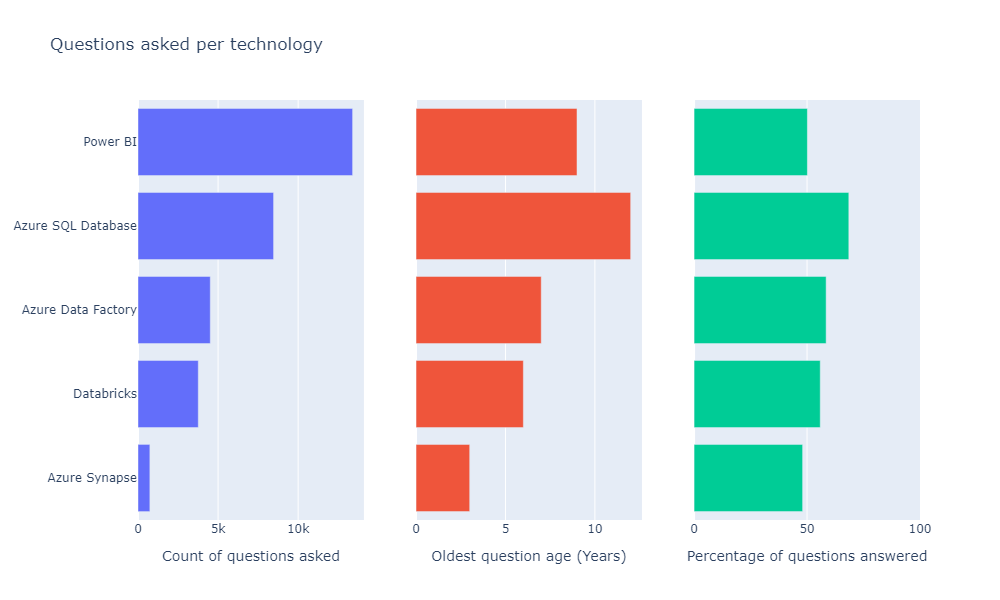

In [22]:
fig = make_subplots(shared_yaxes=True,rows=1, cols=3)
df_agg_sorted = df_agg.sort_values(by=['Question Count'])

fig1 = dict(type='bar',
             x=df_agg_sorted['Question Count'],
             y=df_agg_sorted['Technology'],
             orientation='h',
             )
fig2 = dict(type='bar',
             x=df_agg_sorted['Oldest Question Age'],
             y=df_agg_sorted['Technology'],
             orientation='h',
             )
fig3 = dict(type='bar',
             x=df_agg_sorted['Answered Ratio %'],
             y=df_agg_sorted['Technology'],
             orientation='h',
             )
fig.add_trace(fig1, 1, 1)
fig.add_trace(fig2, 1, 2)
fig.add_trace(fig3, 1, 3)
fig.update_layout(height=600, width=1000, title_text="Questions asked per technology", showlegend=False)
fig.update_xaxes(title_text='Count of questions asked', row=1, col=1)
fig.update_xaxes(title_text='Oldest question age (Years)', row=1, col=2)
fig.update_xaxes(title_text='Percentage of questions answered',range=[0, 100], row=1, col=3)

fig.show("png")

In [23]:
df_description_sql, most_viewed_sql, most_voted_sql, most_viewed_unanswered_sql, most_voted_unanswered_sql = eda(df_sql)
df_description_sql

,creation_timestamp,year,month,answer_count,score,view_count,year_month,comparative_year
count,8.466000e+03,8466.000000,8466.000000,8466.000000,8466.000000,8.466000e+03,8466.000000,8466.000000
mean,1.499525e+09,2017.019017,6.502953,1.372195,1.738365,1.678385e+03,201708.404678,8.019017
std,9.171563e+07,2.894563,3.363057,1.065277,10.931249,1.511349e+04,289.454286,2.894563
min,1.251101e+09,2009.000000,1.000000,0.000000,-5.000000,1.000000e+01,200908.000000,0.000000
25%,1.435027e+09,2015.000000,4.000000,1.000000,0.000000,1.070000e+02,201506.000000,6.000000
50%,1.512045e+09,2017.000000,6.000000,1.000000,1.000000,3.470000e+02,201711.000000,8.000000
75%,1.575208e+09,2019.000000,9.000000,2.000000,2.000000,1.041500e+03,201911.750000,10.000000
max,1.640617e+09,2021.000000,12.000000,22.000000,836.000000,1.234866e+06,202112.000000,12.000000


In [24]:
most_viewed_sql[most_viewed_sql['title'].str.contains('azure', case=False)].head(5)

,title,is_answered,creation_timestamp,creation_date,year,month,answer_count,score,view_count,tags,year_month,comparative_year,Technology
2137,How to view the roles and permissions granted ...,True,1435595467,2015-06-29,2015,6,4,47,160205,"['sql-server', 'azure', 'azure-sql-database', ...",201506,6,Azure SQL Database
1186,How do I create a new user in a SQL Azure data...,True,1380546159,2013-09-30,2013,9,9,81,126479,"['sql-server', 'azure', 'azure-sql-database']",201309,4,Azure SQL Database
123,How do I copy SQL Azure database to my local d...,True,1301413765,2011-03-29,2011,3,22,198,122963,"['sql-server', 'azure', 'azure-sql-database', ...",201103,2,Azure SQL Database
1604,Azure SQL Database &quot;DTU percentage&quot; ...,True,1411025052,2014-09-18,2014,9,5,91,122285,"['azure', 'azure-sql-database', 'azure-storage...",201409,5,Azure SQL Database
740,Password reset for Azure database,True,1355080205,2012-12-09,2012,12,9,106,95616,"['azure', 'azure-sql-database']",201212,3,Azure SQL Database


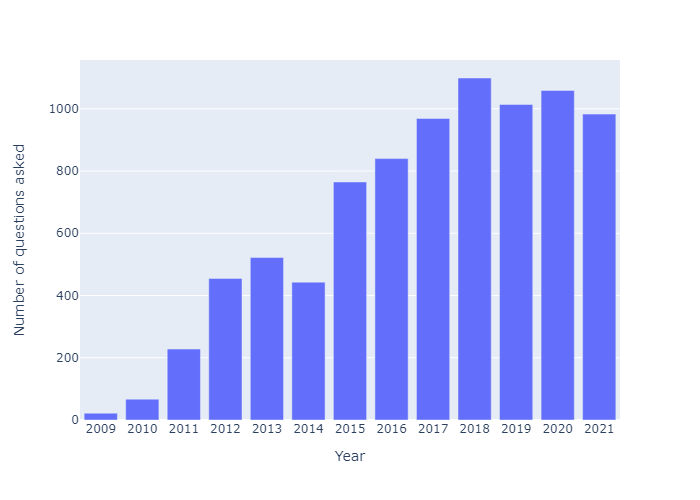

In [26]:
years_view(df_sql)

In [27]:
tags_view(df_sql)[1:11]

[('azure', 4489),
 ('sql-server', 2138),
 ('sql', 1205),
 ('c#', 730),
 ('entity-framework', 353),
 ('tsql', 343),
 ('azure-web-app-service', 308),
 ('azure-data-factory', 260),
 ('azure-sql-server', 256),
 ('azure-active-directory', 238)]

In [28]:
# Number of 'azure-sql-database' tagged questions with 'Azure in the title'
df_qs = df_sql.shape[0]
azure_qs = df_sql[df_sql['title'].str.contains("azure", case=False)].shape[0]
print('Percentage of questions with ''Azure'' in the title: {}%'.format(round(100 * azure_qs/df_qs,2)))

Percentage of questions with Azure in the title: 71.64%


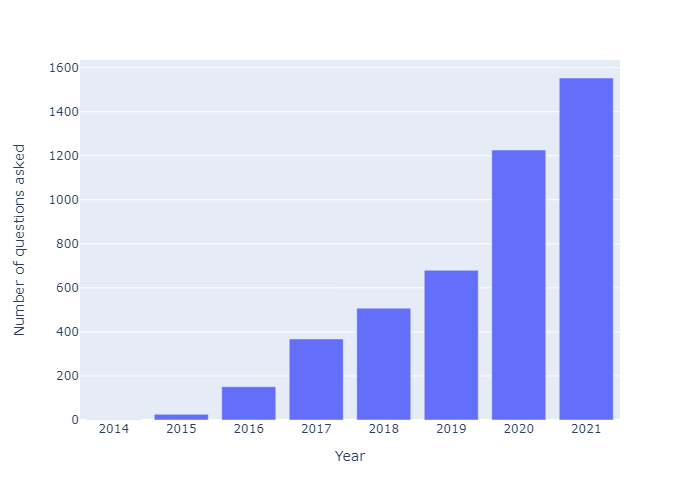

In [29]:
years_view(df_adf)

In [30]:
tags_view(df_adf)[1:11]

[('azure', 2460),
 ('azure-data-factory-2', 1190),
 ('azure-data-factory-pipeline', 284),
 ('azure-data-lake', 280),
 ('azure-sql-database', 256),
 ('azure-blob-storage', 193),
 ('azure-data-flow', 190),
 ('json', 138),
 ('azure-databricks', 126),
 ('sql-server', 121)]

In [31]:
df_description_synapse, most_viewed_synapse, most_voted_synapse, most_viewed_unanswered_synapse, most_voted_unanswered_synapse = eda(df_synapse)
most_viewed_unanswered_synapse.head()

,title,is_answered,creation_timestamp,creation_date,year,month,answer_count,score,view_count,tags,year_month,comparative_year,Technology
154,How to Insert Data into table with select quer...,False,1604185269,2020-10-31,2020,10,2,0,2021,"['sql-server', 'apache-spark', 'create-table',...",202010,2,Azure Synapse
33,Loading data from ADLS Gen 2 into Azure Synapse,False,1589372291,2020-05-13,2020,5,2,1,1867,"['sql-server', 'azure', 'azure-data-lake', 'az...",202005,2,Azure Synapse
56,Connect to Synapse from DataBricks using Servi...,False,1593092422,2020-06-25,2020,6,1,4,1677,"['azure-databricks', 'azure-synapse', 'azure-s...",202006,2,Azure Synapse
14,Read Azure Synapse table with Spark,False,1584956756,2020-03-23,2020,3,2,0,1484,"['apache-spark', 'azure-synapse']",202003,2,Azure Synapse
94,How to implement Sequence in Azure Synapse,False,1598529409,2020-08-27,2020,8,0,1,1164,"['sql-server', 'azure', 'azure-synapse']",202008,2,Azure Synapse


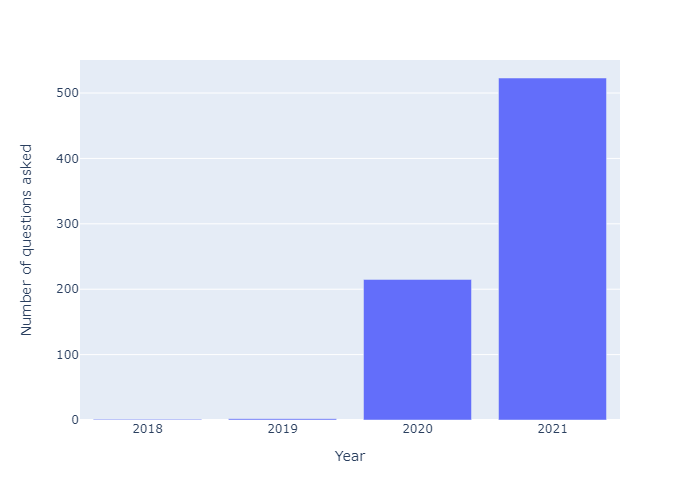

In [32]:
years_view(df_synapse)

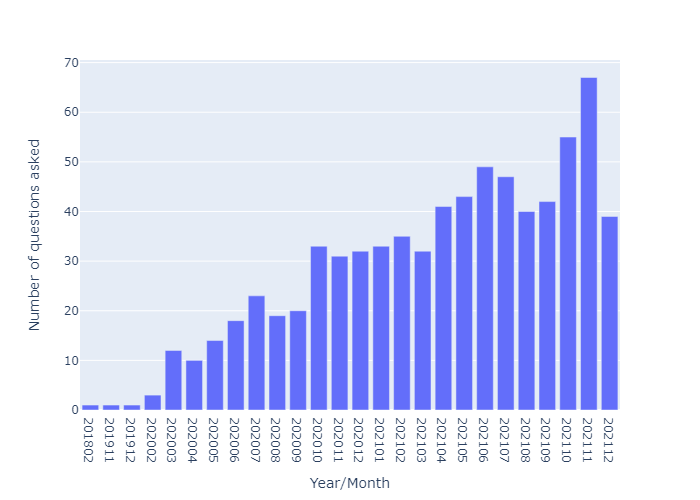

In [33]:
# Synapse is a bit newer, so month-by-month view is suitable here to demonstrate increase over time.
months_view(df_synapse)

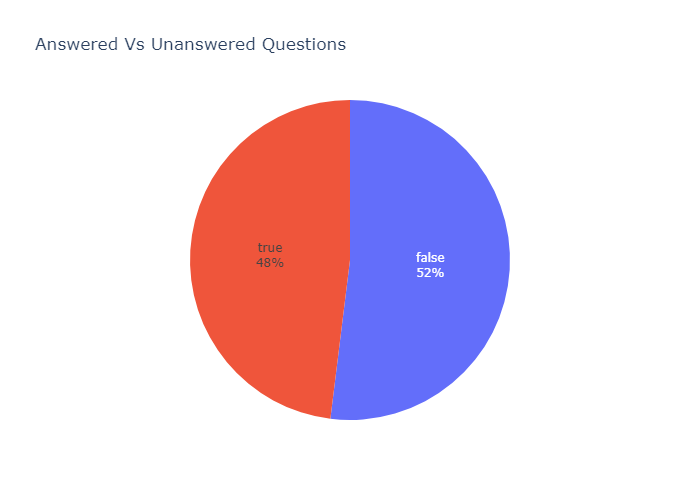

In [34]:
pie_chart(df_synapse)

In [35]:
tags_view(df_synapse)[1:11]

[('azure', 329),
 ('azure-data-factory', 99),
 ('apache-spark', 68),
 ('sql', 64),
 ('azure-sql-data-warehouse', 61),
 ('sql-server', 61),
 ('pyspark', 49),
 ('azure-sql-database', 44),
 ('azure-sqldw', 41),
 ('azure-data-factory-2', 39)]

In [36]:
total_synapse_count = df_synapse.shape[0]
synapse_adf_count = df_synapse[df_synapse['tags'].str.contains('azure-data-factory')].count()[0]
percent_adf = 100 * synapse_adf_count / total_synapse_count
print('Percent of synapse questions related to ADF: {}%'.format(round(percent_adf,2)))

Percent of synapse questions related to ADF: 16.46%


In [37]:
df_description_databricks, most_viewed_databricks, most_voted_databricks, most_viewed_unanswered_databricks, most_voted_unanswered_databricks = eda(df_databricks)
most_viewed_databricks.head()

,title,is_answered,creation_timestamp,creation_date,year,month,answer_count,score,view_count,tags,year_month,comparative_year,Technology
22,Exploding nested Struct in Spark dataframe,True,1472744479,2016-09-01,2016,9,3,27,61335,"['scala', 'apache-spark', 'apache-spark-sql', ...",201609,1,Databricks
796,How to read xlsx or xls files as spark dataframe,True,1559559945,2019-06-03,2019,6,5,8,40097,"['python-3.x', 'azure', 'databricks']",201906,4,Databricks
445,How to solve this error org.apache.spark.sql.c...,True,1540565285,2018-10-26,2018,10,3,13,38674,"['apache-spark', 'datastax-enterprise', 'cassa...",201810,3,Databricks
91,Adding constant value column to spark dataframe,True,1495048387,2017-05-17,2017,5,2,9,36165,"['apache-spark', 'pyspark', 'databricks']",201705,2,Databricks
197,How to slice a pyspark dataframe in two row-wise,True,1519128402,2018-02-20,2018,2,5,16,35845,"['python', 'pyspark', 'spark-dataframe', 'data...",201802,3,Databricks


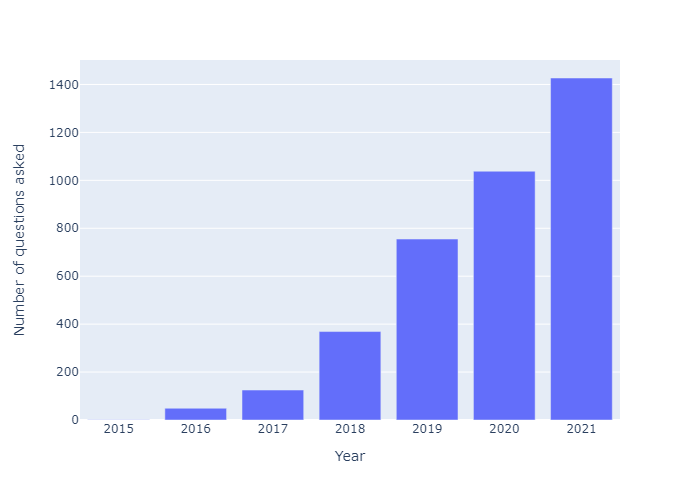

In [38]:
years_view(df_databricks)

In [39]:
# Percentage of databricks questions which have 'azure-databricks' tag
total_count = df_databricks.shape[0]
print('Total question count: {}'.format(total_count))
databricks_tags = tags_view(df_databricks)
azure_databricks_count = [j for i,j in databricks_tags if i == 'azure-databricks'][0]
print('azure-databricks question count: {}'.format(azure_databricks_count))
print('Percent of quiestions with azure-databricks tag: {}%'.format(round(100 * azure_databricks_count /total_count,2)))

Total question count: 3764
azure-databricks question count: 967
Percent of quiestions with azure-databricks tag: 25.69%


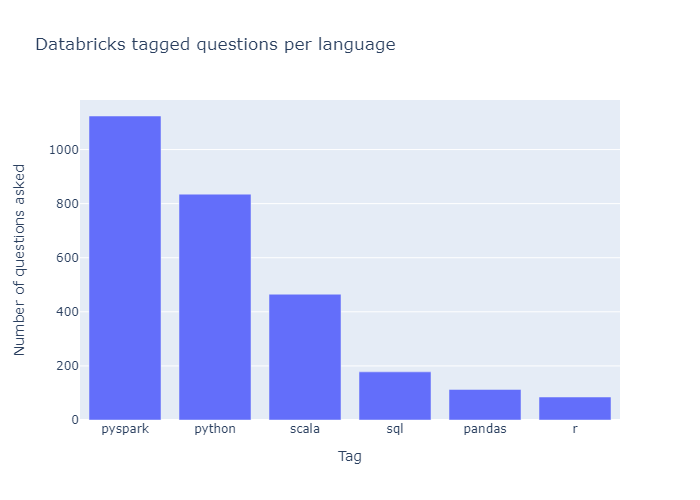

In [40]:
# Count of different language tags
language_tags = ['pyspark','python','scala','sql','r', 'pandas']
tags_df = pd.DataFrame(databricks_tags, columns=['Tag','count'])
tags_df = tags_df[tags_df['Tag'].isin(language_tags)]
fig = px.bar(tags_df,
                x='Tag',
                y='count',
                title='Databricks tagged questions per language',
                labels=dict(count='Number of questions asked'))
fig.show("png")

In [41]:
df_description_powerbi, most_viewed_powerbi, most_voted_powerbi, most_viewed_unanswered_powerbi, most_voted_unanswered_powerbi = eda(df_powerbi)
most_viewed_unanswered_powerbi.head()

,title,is_answered,creation_timestamp,creation_date,year,month,answer_count,score,view_count,tags,year_month,comparative_year,Technology
2161,Measure in Power BI using if statements,False,1523436155,2018-04-11,2018,4,1,2,35596,"['conditional', 'powerbi', 'measure']",201804,6,Power BI
2642,Based on slicer selection create dynamic calcu...,False,1532628793,2018-07-26,2018,7,2,3,19018,['powerbi'],201807,6,Power BI
3391,Power BI - I need a &quot;countif&quot; formul...,False,1543329007,2018-11-27,2018,11,1,0,15570,"['excel-formula', 'powerbi', 'dax', 'countif']",201811,6,Power BI
2665,Bolding values in PowerBI,False,1533036332,2018-07-31,2018,7,2,2,13797,['powerbi'],201807,6,Power BI
3134,Re-ordering the x-axis values in Power BI - &q...,False,1539386612,2018-10-13,2018,10,2,2,12164,"['sorting', 'powerbi', 'dax']",201810,6,Power BI


In [42]:
tags_view(df_powerbi)[1:11]

[('dax', 4701),
 ('powerbi-desktop', 2065),
 ('powerquery', 1520),
 ('excel', 689),
 ('powerbi-embedded', 655),
 ('m', 509),
 ('powerbi-datasource', 456),
 ('azure', 446),
 ('sql', 331),
 ('powerpivot', 321)]

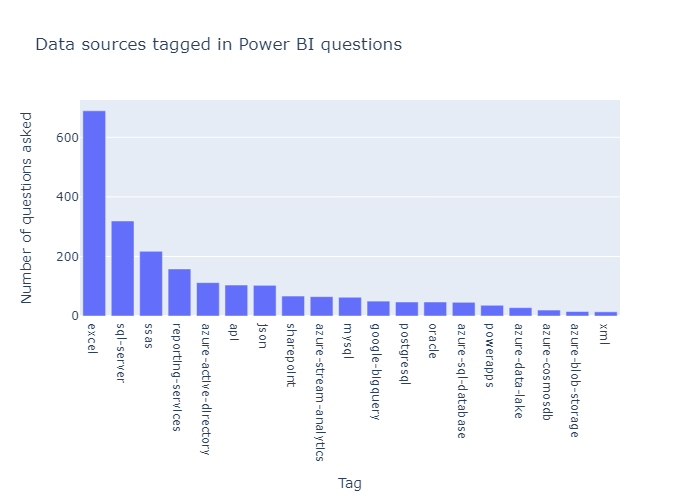

In [43]:
# Count of different data source tags
powerbi_tags = tags_view(df_powerbi)
source_tags = ['excel','ssas','reporting-services', 'azure-active-directory', 'api',
               'sharepoint','azure-stream-analytics','json','sql-server','mysql',
              'google-bigquery','postgresql','oracle','azure-sql-database','powerapps',
              'azure-data-lake','azure-cosmosdb','azure-blob-storage','xml']
sources_df = pd.DataFrame(powerbi_tags, columns=['Tag','count'])
sources_df = sources_df[sources_df['Tag'].isin(source_tags)]
fig = px.bar(sources_df,
                x='Tag',
                y='count',
                title='Data sources tagged in Power BI questions',
                labels=dict(count='Number of questions asked'))
fig.show("png")

In [349]:
# Save DataFrames
df_sql.to_csv('df_sql.csv',index=False)
df_mi.to_csv('df_mi.csv',index=False)
df_adf.to_csv('df_adf.csv',index=False)
df_synapse.to_csv('df_synapse.csv',index=False)
df_databricks.to_csv('df_databricks.csv',index=False)
df_powerbi.to_csv('df_powerbi.csv',index=False)
df_all.to_csv('df_all',index=False)